In [1]:
import cv2
import math
import numpy as np

# change the filename to choose the image
img = cv2.imread('data/IMG_6720.jpg')



# convert input image to gray scale
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# If pixel value is greater than a threshold value, it is assigned  white, otherwise black
retval, thresholdedimage = cv2.threshold(imgray, 200, 255, cv2.THRESH_BINARY)

# find the contours of the image
contourimage, contours, hierarchy = cv2.findContours(thresholdedimage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#delete the outer contour which include the white paper
contours.pop(0);

In [2]:
# find the convex Hull(outer rotated rect) of all the small contours
all_cont = contours[0]
for i in range(1, len(contours)):
    all_cont = np.concatenate((all_cont, contours[i]))

# find the four vertices of a rotated rect
rect = cv2.minAreaRect(all_cont)
box = cv2.boxPoints(rect)
box = np.int0(box)

# see if the contour hull is what we want or not.
cv2.drawContours(img, [box], 0, (0, 0, 255), 2)
cv2.imshow("image with contours", img)
cv2.waitKey()

# assign the position of the vertex of the rotated rect.
top_left = box[1]
top_right = box[0]
bot_left = box[2]
bot_right = box[3]
print box

[[ 939 1599]
 [ 936 1356]
 [1220 1353]
 [1223 1596]]


In [3]:
# the QR code vertex position in image
object_2d_points = np.float32([top_left,bot_left,bot_right,top_right])

# the QR code vertex position in real world
object_3d_points = np.float32([[-44,44, 0], [-44,-44, 0], [44,-44, 0], [44,44, 0]])

#Define the camera distortion coefficients to be zero
dist_coefs = np.zeros(4)

#Define the camera intrinsic matrix given the spec of iPhone camera reference as below:
#http://ksimek.github.io/2013/08/13/intrinsic/
#https://stackoverflow.com/questions/34963337/iphone-6-camera-calibration-for-opencv
fx=2803
cx=1224
fy=2803
cy=1632

camera_matrix = np.float32([[fx, 0, cx],
                            [0, fy, cy],
                            [0.0,0.0, 1.0]])

# solve the PnP problem using OpenCV function and get the rotation and translation matrix
# reference is as below: 
# https://stackoverflow.com/questions/18637494/camera-position-in-world-coordinate-from-cvsolvepnp
found,rvec,tvec = cv2.solvePnP(object_3d_points, object_2d_points, camera_matrix, dist_coefs)
rotM = cv2.Rodrigues(rvec)[0]
cameraPosition = -np.matrix(rotM).T * np.matrix(tvec)

In [4]:
#Given the rotation matrix, compute the rotation angle of each axis, the result is degree format
def rotationMatrix2Angle(R):
    x=math.atan2(R[2][1],R[2][2])/2/math.pi*360.0
    y=math.atan2(-R[2][0],math.sqrt(R[2][1]*R[2][1]+R[2][2]*R[2][2]))/2/math.pi*360.0
    z=math.atan2(R[1][0],R[0][0])/2/math.pi*360.0
    return [x,y,z]

#Calculate the rotation angle from rotation matrix
angle=rotationMatrix2Angle(rotM)

print "The location of camera is:",cameraPosition[0]/10.0,cameraPosition[1]/10.0,cameraPosition[2]/10.0, "cm"
print "the angle of the camera is:", "Pitch:", angle[0], "Yaw:", angle[1], "Roll:", angle[2]

The location of camera is: [[ 44.68660736]] [[-0.15462776]] [[-75.23820496]] cm
the angle of the camera is: Pitch: -3.15372519265 Yaw: 27.3940335787 Roll: 87.7824813285


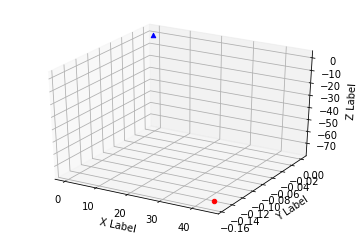

In [5]:
# visulization: the red circle stands for the position of camera, the blue triangle stands for the position of graph
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

cx = cameraPosition[0]/10.0
cy = cameraPosition[1]/10.0
cz = cameraPosition[2]/10.0

ox = 0
oy = 0
oz = 0

ax.scatter(cx, cy, cz, c='r', marker='o')
ax.scatter(ox, oy, oz, c='b', marker='^')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()